# <font color='green'>Best Model so far:</color>
## <font color='green'><font color='green'>Predicting Weeks w/o normalization + categories multihot: 47.912% correct (Trainingset)</color>

# XGBoost on GPU
## Predicting the time difference (weeks) to next repurchase

### Methods & Settings

In [167]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">HIDE/SHOW CONTENT</a>.''')
display(tag)

############### Write code below ##################

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import gc
import joblib

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:75% !important; }</style>"))

pd.set_option('display.max_rows', 250)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 50)

####
# prints memory usage
def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB\n'.format(start_mem))
    return

####
# seperates features from label (y must be last column)
def sep_X_y(df):
    X = df.iloc[:,0:-1] # extracts all rows [:] and columns from 0 to next-to-last [0:-1]
    y = df.iloc[:,-1] # extracts all rows [:] and only last column [-1]
    
    return [X, y]

####
# split training and test set from given dataframe with month as boundaries
def mth_train_test_split(df, mth_start, mth_end):
    print('Splitting dataframe...\n')
    
    # get indices from desired boundaries
    idx_start = df.month.searchsorted(mth_start_train, side='left') # list needs to be sorted already for searchsorted
    idx_end = df.month.searchsorted(mth_end_train + 1, side='left')
    
    df = df.iloc[idx_start:idx_end]
    
    return df

####
# trains XGB model (regressor)
def train_xgb(X, y):
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    fitted_model = model.fit(X, y)
    
    #print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain', max_num_features=25)
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

def train_xgb_bestHyper(X, y):
    X_train = X
    y_train = y
    space = best_hyperparams
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0,
                    eta = space['eta'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    fitted_model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain')
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

def train_dtc(X, y):
    X_train = X
    y_train = y
    
    print('Fitting model...\n')
    model = DecisionTreeRegressor()
    fitted_model = model.fit(X_train, y_train)
    
    #print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    #xgb.plot_importance(model, importance_type='gain')
    #plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

####
# predicts labels of training and test with given model
def predict_values(model, X, y_true):
    print('Predicting values...\n')
    # predict y values
    y_pred = model.predict(X)
    
    # get msq
    model_error = mean_squared_error(y_true, y_pred)
    
    # print info about accuracies
    print(f'\t\t\t\t\t\033[1m XGboost Regressor RMSE: '
          f'\033[4m\033[1m{model_error:.3f}')
    
    # return predicted values
    return y_pred

####
# concatenates prediction with actual target for evaluation
def concat_ytrue_ypred(X, y_true, y_pred):
    # create dataframe from test-prediction with index from X_test
    df_y_pred = pd.DataFrame(y_pred, columns=['nextBuyIn_pred'], index=X.index, dtype=np.int8)

    # concatenate X, y, y_pred (put columns next to each other)
    df_eval = pd.concat([X, y_true, df_y_pred], axis=1)
    
    return df_eval

####
# executes all needed functions of the above with given training and test data and provided train method
# def execute_pipeline(train_method, df, start_mth, end_mth):
#     b = list_of_four_df_boundaries
#     # split dataframe in train/test and X/y
#     X_train, y_train, X_test, y_test = dt_train_test_split(df, b[0], b[1], b[2], b[3])
    
#     #train model
#     model = train_method(X_train, y_train)    
    
#     # make predictions
#     pred_train, pred_test = predict_values(model, X_train, y_train, X_test, y_test)
    
#     print('\nExecuted pipeline.\nEvaluate with "evaluate_pred(X, y, y_pred)"\n')
#     return [pred_train, pred_test, X_train, y_train, X_test, y_test]

### Read files

In [2]:
file = r'C:\Users\LEAND\Coding\Jupyter Notebooks\csv\220623_complete_feature-list_orderhistory_trainingOhneNull.csv' # scores calculated with data from jun-oct

columns = [#'date',
           'userID', 
           'itemID',
           'order', 
           'brand', 
           'feature_1', 
           'feature_2', 
           'feature_3', 
           'feature_4', 
           'feature_5',
           'brandOrderRatio',
           'feature1OrderRatio',
           'feature2OrderRatio',
           'feature3OrderRatio',
           'feature4OrderRatio',
           'feature5OrderRatio',
           'TotalBFscore',
           'RCP',
           'MeanDiffToNxt(user)',
           'TotalItemOrders(user)',
           #'TotalItemOrders(item)',
           'date(year)',
           'date(month)',
           'date(weekOfMonth)',
           'date(dayOfMonth)',
           'date(weekOfYear)',
           'date(dayOfYear)',
           #'nextBuyInWeeks(round)', # label
           'nextBuyInWeeks(floor)', # label
           #'nextBuyInWeekOfYear' # label; schlechte idee
          ]

dtype = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8,
         'nextBuyInWeeks(floor)':np.uint8
        }

---

# Predicting Weeks NORMALIZED VALUES

In [3]:
df = pd.read_csv(file, usecols=columns, sep='|', dtype=dtype, nrows=None)

show_mem_usage(df)
df.head()

Memory usage of dataframe is 15.71 MB



,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor)
0,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.0,2020,6,1,1,23,153,24
1,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.5,2020,6,1,1,23,153,22
2,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.5,2020,6,1,1,23,153,22
3,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.0,2020,6,1,1,23,153,4
4,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.5,2020,6,1,1,23,153,4


## Preparation

In [4]:
# save column names
column_headers = list(df.columns)

In [5]:
# split DF in X & y
X_train, y_train = sep_X_y(df)

# normalize X, y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(pd.DataFrame(y_train))

In [6]:
# rename columns
X_train = pd.DataFrame(X_train)
X_train.set_axis(column_headers[:-1], axis=1,inplace=True)

y_train = pd.DataFrame(y_train)
y_train.set_axis([column_headers[-1]], axis=1,inplace=True)

## Training & Prediction

## XGBoost Regressor

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

Fitting model...

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27



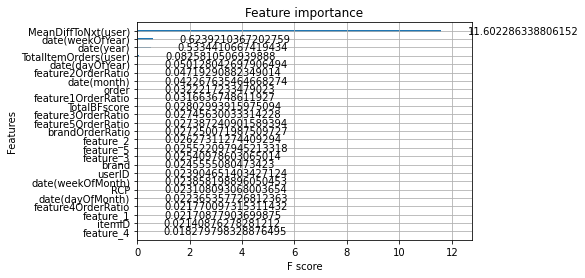

In [7]:
model = train_xgb(X_train, y_train)

In [8]:
y_pred = predict_values(model, X_train, y_train)

Predicting values...

					 XGboost Regressor RMSE: 0.004


### Evaluation

In [9]:
dtype_X = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8
        }
dtype_y = {'nextBuyInWeeks(floor)':np.uint8}

# denormalize and convert back to dataframe
X_train = pd.DataFrame(scaler_X.inverse_transform(X_train))
y_train = pd.DataFrame(scaler_y.inverse_transform(y_train)).astype(np.uint8)
y_pred = pd.DataFrame(scaler_y.inverse_transform(pd.DataFrame(y_pred))).apply(lambda x: round(x)).astype(np.uint8)

# rename columns
X_train.set_axis(column_headers[:-1], axis=1,inplace=True)
y_train.set_axis([column_headers[-1]], axis=1,inplace=True)
y_pred.set_axis(['nextBuyIn_pred'], axis=1,inplace=True)

In [10]:
# concatenate X, y, y_pred (columns next to each other)
df_eval = pd.concat([X_train, y_train, y_pred], axis=1)
df_eval.loc[df_eval['nextBuyInWeeks(floor)'] == df_eval['nextBuyIn_pred']]

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor),nextBuyIn_pred
0,76.0,23050.0,1.0,1411.0,4.0,0.0,22.0,0.0,151.0,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2.0,169.000000,2020.0,6.0,1.0,1.0,23.0,153.0,24,24
3,135.0,13660.0,1.0,157.0,4.0,0.0,513.0,0.0,137.0,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2.0,32.000000,2020.0,6.0,1.0,1.0,23.0,153.0,4,4
5,202.0,26940.0,1.0,1258.0,4.0,0.0,487.0,3.0,44.0,0.001213,0.466804,0.826492,0.024224,0.334600,0.059138,0.816166,0.123867,3.0,77.000000,2020.0,6.0,1.0,1.0,23.0,153.0,11,11
8,244.0,10341.0,1.0,1025.0,6.0,0.0,198.0,0.0,17.0,0.002099,0.152436,0.826492,0.000869,0.640224,0.078879,0.810581,0.228986,3.0,109.000000,2020.0,6.0,1.0,1.0,23.0,153.0,15,15
12,388.0,26662.0,1.0,523.0,10.0,0.0,503.0,3.0,17.0,0.007154,0.369146,0.826492,0.062924,0.334600,0.078879,0.799966,0.137931,2.0,121.000000,2020.0,6.0,1.0,1.0,23.0,153.0,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171588,19482.0,1782.0,1.0,6.0,4.0,3.0,321.0,0.0,144.0,0.022353,0.466804,0.056881,0.012406,0.640224,0.086085,0.607925,0.126566,7.0,32.000000,2021.0,1.0,3.0,24.0,3.0,24.0,1,1
171589,21517.0,594.0,1.0,203.0,4.0,1.0,491.0,0.0,66.0,0.000426,0.466804,0.100607,0.037829,0.640224,0.036075,0.606568,0.666667,7.0,23.250000,2021.0,1.0,3.0,24.0,3.0,24.0,1,1
171590,21517.0,19443.0,1.0,408.0,10.0,0.0,160.0,0.0,38.0,0.010779,0.369146,0.826492,0.000887,0.640224,0.006478,0.885075,0.226415,8.0,30.142857,2021.0,1.0,3.0,24.0,3.0,24.0,1,1
171591,36052.0,23148.0,1.0,1401.0,4.0,0.0,145.0,0.0,163.0,0.003575,0.466804,0.826492,0.001867,0.640224,0.017563,0.934988,0.251366,4.0,74.000000,2021.0,1.0,3.0,24.0,3.0,24.0,1,1


In [12]:
rowcount = len(df_eval)
should = rowcount
is_ = len(df_eval.loc[(df_eval['nextBuyInWeeks(floor)'] == df_eval.nextBuyIn_pred)]) 

print(f'\033[1mrow count of set:\t\t\t\t {rowcount}')
print(f'\033[1mrows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 171593
rows where label was predicted correctly:	 67265 	 (39.200 % of rows)


---

# Predicting Weeks NORMALIZED W/O LABEL

## Preparation

In [65]:
df = pd.read_csv(file, usecols=columns, sep='|', dtype=dtype, nrows=None)

show_mem_usage(df)
df.head()

Memory usage of dataframe is 15.71 MB



,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor)
0,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.0,2020,6,1,1,23,153,24
1,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.5,2020,6,1,1,23,153,22
2,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.5,2020,6,1,1,23,153,22
3,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.0,2020,6,1,1,23,153,4
4,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.5,2020,6,1,1,23,153,4


In [66]:
# save column names
column_headers = list(df.columns)

In [67]:
# split DF in X & y
X_train, y_train = sep_X_y(df)

# normalize X
scaler_X = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)

In [68]:
# rename columns
X_train = pd.DataFrame(X_train)
X_train.set_axis(column_headers[:-1], axis=1,inplace=True)

## Training & Prediction

## XGBoost Regressor

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

Fitting model...

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27



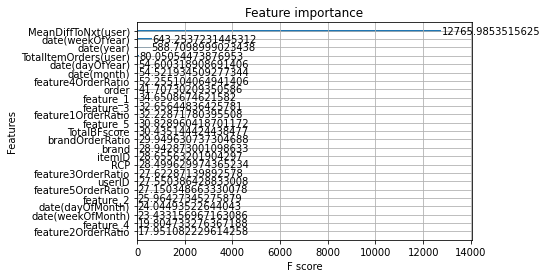

In [69]:
model = train_xgb(X_train, y_train)

In [70]:
y_pred = predict_values(model, X_train, y_train)

Predicting values...

					 XGboost Regressor RMSE: 4.780


### Evaluation

In [71]:
dtype_X = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8
        }
dtype_y = {'nextBuyInWeeks(floor)':np.uint8}

# denormalize and convert back to dataframe
X_train = pd.DataFrame(scaler_X.inverse_transform(X_train))
y_pred = pd.DataFrame(y_pred).apply(lambda x: round(x)).astype(np.uint8)

# rename columns
X_train.set_axis(column_headers[:-1], axis=1,inplace=True)
y_pred.set_axis(['nextBuyIn_pred'], axis=1,inplace=True)

In [72]:
# concatenate X, y, y_pred (columns next to each other)
df_eval = pd.concat([X_train, y_train, y_pred], axis=1)
df_eval.loc[df_eval['nextBuyInWeeks(floor)'] == df_eval['nextBuyIn_pred']]

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor),nextBuyIn_pred
0,76.0,23050.0,1.0,1411.0,4.0,0.0,22.0,0.0,151.0,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2.0,169.000000,2020.0,6.0,1.0,1.0,23.0,153.0,24,24
3,135.0,13660.0,1.0,157.0,4.0,0.0,513.0,0.0,137.0,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2.0,32.000000,2020.0,6.0,1.0,1.0,23.0,153.0,4,4
5,202.0,26940.0,1.0,1258.0,4.0,0.0,487.0,3.0,44.0,0.001213,0.466804,0.826492,0.024224,0.334600,0.059138,0.816166,0.123867,3.0,77.000000,2020.0,6.0,1.0,1.0,23.0,153.0,11,11
6,240.0,7318.0,1.0,1335.0,6.0,0.0,421.0,3.0,6.0,0.000549,0.152436,0.826492,0.021874,0.334600,0.002002,0.633827,0.279570,2.0,71.000000,2020.0,6.0,1.0,1.0,23.0,153.0,10,10
7,240.0,26645.0,1.0,648.0,10.0,0.0,358.0,3.0,24.0,0.001713,0.369146,0.826492,0.009509,0.334600,0.004315,0.735008,0.106439,2.0,71.000000,2020.0,6.0,1.0,1.0,23.0,153.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171587,10466.0,10299.0,1.0,225.0,10.0,0.0,393.0,3.0,121.0,0.008169,0.369146,0.826492,0.001919,0.334600,0.003068,0.733848,0.129808,2.0,7.000000,2021.0,1.0,3.0,24.0,3.0,24.0,1,1
171588,19482.0,1782.0,1.0,6.0,4.0,3.0,321.0,0.0,144.0,0.022353,0.466804,0.056881,0.012406,0.640224,0.086085,0.607925,0.126566,7.0,32.000000,2021.0,1.0,3.0,24.0,3.0,24.0,1,1
171590,21517.0,19443.0,1.0,408.0,10.0,0.0,160.0,0.0,38.0,0.010779,0.369146,0.826492,0.000887,0.640224,0.006478,0.885075,0.226415,8.0,30.142857,2021.0,1.0,3.0,24.0,3.0,24.0,1,1
171591,36052.0,23148.0,1.0,1401.0,4.0,0.0,145.0,0.0,163.0,0.003575,0.466804,0.826492,0.001867,0.640224,0.017563,0.934988,0.251366,4.0,74.000000,2021.0,1.0,3.0,24.0,3.0,24.0,1,1


In [73]:
rowcount = len(df_eval)
should = rowcount
is_ = len(df_eval.loc[(df_eval['nextBuyInWeeks(floor)'] == df_eval.nextBuyIn_pred)]) 

print(f'\033[1mrow count of set:\t\t\t\t {rowcount}')
print(f'\033[1mrows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 171593
rows where label was predicted correctly:	 80519 	 (46.924 % of rows)


---

# Predicting Weeks w/o normalization

## Preparation

In [90]:
df = pd.read_csv(file, usecols=columns, sep='|', dtype=dtype, nrows=None)

show_mem_usage(df)
df.head()

Memory usage of dataframe is 15.71 MB



,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor)
0,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.0,2020,6,1,1,23,153,24
1,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.5,2020,6,1,1,23,153,22
2,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.5,2020,6,1,1,23,153,22
3,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.0,2020,6,1,1,23,153,4
4,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.5,2020,6,1,1,23,153,4


In [91]:
# save column names
column_headers = list(df.columns)

In [92]:
# split DF in X & y
X_train, y_train = sep_X_y(df)

## Training & Prediction

## XGBoost Regressor

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

Fitting model...

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27



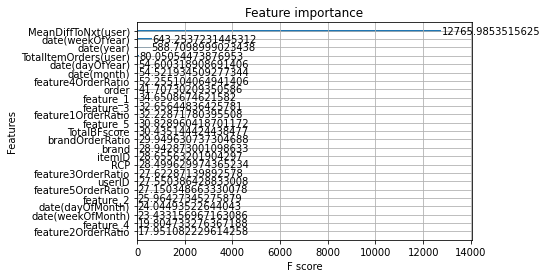

In [93]:
model = train_xgb(X_train, y_train)

In [94]:
y_pred = predict_values(model, X_train, y_train)

Predicting values...

					 XGboost Regressor RMSE: 4.780


### Evaluation

In [95]:
dtype_X = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8
        }
dtype_y = {'nextBuyInWeeks(floor)':np.uint8}

y_pred = pd.DataFrame(y_pred).apply(lambda x: round(x)).astype(np.uint8)

y_pred.set_axis(['nextBuyIn_pred'], axis=1,inplace=True)

In [96]:
# concatenate X, y, y_pred (columns next to each other)
df_eval = pd.concat([X_train, y_train, y_pred], axis=1)
df_eval.loc[df_eval['nextBuyInWeeks(floor)'] == df_eval['nextBuyIn_pred']]

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor),nextBuyIn_pred
0,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.000000,2020,6,1,1,23,153,24,24
3,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.000000,2020,6,1,1,23,153,4,4
5,202,26940,1,1258,4,0,487,3,44,0.001213,0.466804,0.826492,0.024224,0.334600,0.059138,0.816166,0.123867,3,77.000000,2020,6,1,1,23,153,11,11
6,240,7318,1,1335,6,0,421,3,6,0.000549,0.152436,0.826492,0.021874,0.334600,0.002002,0.633827,0.279570,2,71.000000,2020,6,1,1,23,153,10,10
7,240,26645,1,648,10,0,358,3,24,0.001713,0.369146,0.826492,0.009509,0.334600,0.004315,0.735008,0.106439,2,71.000000,2020,6,1,1,23,153,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171587,10466,10299,1,225,10,0,393,3,121,0.008169,0.369146,0.826492,0.001919,0.334600,0.003068,0.733848,0.129808,2,7.000000,2021,1,3,24,3,24,1,1
171588,19482,1782,1,6,4,3,321,0,144,0.022353,0.466804,0.056881,0.012406,0.640224,0.086085,0.607925,0.126566,7,32.000000,2021,1,3,24,3,24,1,1
171590,21517,19443,1,408,10,0,160,0,38,0.010779,0.369146,0.826492,0.000887,0.640224,0.006478,0.885075,0.226415,8,30.142857,2021,1,3,24,3,24,1,1
171591,36052,23148,1,1401,4,0,145,0,163,0.003575,0.466804,0.826492,0.001867,0.640224,0.017563,0.934988,0.251366,4,74.000000,2021,1,3,24,3,24,1,1


In [97]:
rowcount = len(df_eval)
should = rowcount
is_ = len(df_eval.loc[(df_eval['nextBuyInWeeks(floor)'] == df_eval.nextBuyIn_pred)]) 

print(f'\033[1mrow count of set:\t\t\t\t {rowcount}')
print(f'\033[1mrows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 171593
rows where label was predicted correctly:	 80519 	 (46.924 % of rows)


---

# <font color='green'>Predicting Weeks w/o normalization + categories multihot</color>

In [196]:
file = r'C:\Users\LEAND\Coding\Jupyter Notebooks\csv\220623_complete_feature-list_orderhistory_trainingOhneNull.csv' # scores calculated with data from jun-oct

columns = [#'date',
           'userID', 
           'itemID',
           'order', 
           'brand', 
           'feature_1', 
           'feature_2', 
           'feature_3', 
           'feature_4', 
           'feature_5',
           'categories',
           'brandOrderRatio',
           'feature1OrderRatio',
           'feature2OrderRatio',
           'feature3OrderRatio',
           'feature4OrderRatio',
           'feature5OrderRatio',
           'TotalBFscore',
           'RCP',
           'MeanDiffToNxt(user)',
           'TotalItemOrders(user)',
           #'TotalItemOrders(item)',
           'date(year)',
           'date(month)',
           'date(weekOfMonth)',
           'date(dayOfMonth)',
           'date(weekOfYear)',
           'date(dayOfYear)',
           #'nextBuyInWeeks(round)', # label
           'nextBuyInWeeks(floor)', # label
           #'nextBuyInWeekOfYear' # label; schlechte idee
          ]

dtype = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8,
         'nextBuyInWeeks(floor)':np.uint8
        }

label = 'nextBuyInWeeks(floor)'

## Preparation

In [197]:
df = pd.read_csv(file, usecols=columns, sep='|', dtype=dtype, nrows=None, converters={
    'categories': lambda x: [int(i) for i in x[1:-1].split(',')]
})

# add fake column for ensuring all categories from 0 to 4299 are included
df.loc[len(df)] = [0 if column != 'categories' else [cat for cat in range(0,4300)] for column in df.columns]
df.index = df.index + 1  # add index

show_mem_usage(df)
df

Memory usage of dataframe is 36.66 MB



,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor)
1,76,23050,1,1411,4,0,22,0,151,"[545, 1763, 3912, 3300, 3586, 3914, 3915, 3962...",0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.000000,2020,6,1,1,23,153,24
2,116,9408,1,322,4,0,536,0,144,"[1394, 2435]",0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.500000,2020,6,1,1,23,153,22
3,116,25677,1,322,4,0,536,0,144,"[1922, 3393]",0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.500000,2020,6,1,1,23,153,22
4,135,13660,1,157,4,0,513,0,137,"[74, 277, 3953]",0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.000000,2020,6,1,1,23,153,4
5,135,22174,1,504,10,0,441,3,84,"[2591, 2312, 2708]",0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.500000,2020,6,1,1,23,153,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171590,21517,594,1,203,4,1,491,0,66,"[1920, 3923]",0.000426,0.466804,0.100607,0.037829,0.640224,0.036075,0.606568,0.666667,7,23.250000,2021,1,3,24,3,24,1
171591,21517,19443,1,408,10,0,160,0,38,"[1871, 3228]",0.010779,0.369146,0.826492,0.000887,0.640224,0.006478,0.885075,0.226415,8,30.142857,2021,1,3,24,3,24,1
171592,36052,23148,1,1401,4,0,145,0,163,"[1705, 975, 388, 3914, 1524, 1807]",0.003575,0.466804,0.826492,0.001867,0.640224,0.017563,0.934988,0.251366,4,74.000000,2021,1,3,24,3,24,1
171593,44941,1173,1,196,10,0,503,0,-1,[2197],0.000146,0.369146,0.826492,0.062924,0.640224,0.000000,0.906948,0.066667,2,7.000000,2021,1,3,24,3,24,1


In [198]:
# multi-hot-encode categories
cats = df["categories"]
mlb = MultiLabelBinarizer(sparse_output=False) # Set to True if output binary array is desired in CSR sparse format
df_multi_hot = pd.DataFrame(mlb.fit_transform(cats), columns=mlb.classes_, index=df.index, dtype=np.int8).astype(pd.SparseDtype(np.uint8,0)) # NaN filled with 0

# drop fake rows from both dataframes (last row) & drop category '9999' standing for missing category
df_multi_hot.drop(index=df.index[-1], axis=0, inplace=True)
df_multi_hot = df_multi_hot.iloc[:,:-1]
df.drop(index=df.index[-1], axis=0, inplace=True)

# join new binarized columns with rest of dataframe
df = df.join(df_multi_hot, how='inner')

if (len(df[df.isnull().any(axis=1)]) > 0):
    raise RuntimeError('Join of multi-hot-encoded categories probably created missing values.')

# drop list of categories, since it's not needed anymore
df.drop('categories', axis=1, inplace=True)

# pop and append 'week' at end of dataframe
col = df.pop(label)
df.insert(len(df.columns), col.name, col)

del df_multi_hot
gc.collect()

df

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),...,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297,4298,4299,nextBuyInWeeks(floor)
1,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24
2,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22
3,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22
4,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
5,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171589,19482,1782,1,6,4,3,321,0,144,0.022353,0.466804,0.056881,0.012406,0.640224,0.086085,0.607925,0.126566,7,32.000000,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
171590,21517,594,1,203,4,1,491,0,66,0.000426,0.466804,0.100607,0.037829,0.640224,0.036075,0.606568,0.666667,7,23.250000,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
171591,21517,19443,1,408,10,0,160,0,38,0.010779,0.369146,0.826492,0.000887,0.640224,0.006478,0.885075,0.226415,8,30.142857,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
171592,36052,23148,1,1401,4,0,145,0,163,0.003575,0.466804,0.826492,0.001867,0.640224,0.017563,0.934988,0.251366,4,74.000000,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [199]:
# save column names
column_headers = list(df.columns)

In [200]:
# split DF in X & y
X_train, y_train = sep_X_y(df)
X_train

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),...,4275,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297,4298,4299
1,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171589,19482,1782,1,6,4,3,321,0,144,0.022353,0.466804,0.056881,0.012406,0.640224,0.086085,0.607925,0.126566,7,32.000000,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
171590,21517,594,1,203,4,1,491,0,66,0.000426,0.466804,0.100607,0.037829,0.640224,0.036075,0.606568,0.666667,7,23.250000,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
171591,21517,19443,1,408,10,0,160,0,38,0.010779,0.369146,0.826492,0.000887,0.640224,0.006478,0.885075,0.226415,8,30.142857,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
171592,36052,23148,1,1401,4,0,145,0,163,0.003575,0.466804,0.826492,0.001867,0.640224,0.017563,0.934988,0.251366,4,74.000000,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Training & Prediction

## XGBoost Regressor

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

Fitting model...

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27



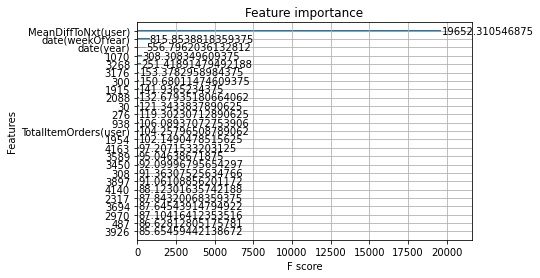

In [184]:
model = train_xgb(X_train, y_train)

In [208]:
y_pred = predict_values(model, X_train, y_train)

Predicting values...

					 XGboost Regressor RMSE: 5.004


### Evaluation

In [209]:
dtype_X = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16,
         'TotalItemOrders(user)':np.uint16,
         'date(year)':np.uint16,
         'date(month)':np.uint8,
         'date(weekOfMonth)':np.uint8,
         'date(dayOfMonth)':np.uint8,
         'date(weekOfYear)':np.uint8,
         'date(dayOfYear)':np.uint8
        }
dtype_y = {'nextBuyInWeeks(floor)':np.uint8}

y_pred = pd.DataFrame(y_pred, index=y_train.index).apply(lambda x: round(x)).astype(np.uint8)

y_pred.set_axis(['nextBuyIn_pred'], axis=1,inplace=True)

In [211]:
# concatenate X, y, y_pred (columns next to each other)
df_eval = pd.concat([X_train, y_train, y_pred], axis=1)
df_eval

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),...,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297,4298,4299,nextBuyInWeeks(floor),nextBuyIn_pred
1,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,24
2,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,18
3,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,16
4,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.000000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4
5,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.500000,2020,6,1,1,23,153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171589,19482,1782,1,6,4,3,321,0,144,0.022353,0.466804,0.056881,0.012406,0.640224,0.086085,0.607925,0.126566,7,32.000000,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
171590,21517,594,1,203,4,1,491,0,66,0.000426,0.466804,0.100607,0.037829,0.640224,0.036075,0.606568,0.666667,7,23.250000,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
171591,21517,19443,1,408,10,0,160,0,38,0.010779,0.369146,0.826492,0.000887,0.640224,0.006478,0.885075,0.226415,8,30.142857,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
171592,36052,23148,1,1401,4,0,145,0,163,0.003575,0.466804,0.826492,0.001867,0.640224,0.017563,0.934988,0.251366,4,74.000000,2021,1,3,24,3,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [212]:
rowcount = len(df_eval)
should = rowcount
is_ = len(df_eval.loc[(df_eval['nextBuyInWeeks(floor)'] == df_eval.nextBuyIn_pred)]) 

print(f'\033[1mrow count of set:\t\t\t\t {rowcount}')
print(f'\033[1mrows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 171593
rows where label was predicted correctly:	 82214 	 (47.912 % of rows)


---

---

---

---

## Hyperparameter Tuning

In [49]:
!pip install hyperopt

  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=e9ee614eafe78c4e768188ae79215eb60d1e7738ab67a895e712001dd53ab0ee
  Stored in directory: c:\users\leand\appdata\local\pip\cache\wheels\22\73\06\557dc4f4ef68179b9d763930d6eec26b88ed7c389b19588a1c
Successfully built future


In [50]:
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {
        'eta': hp.quniform('eta', 0.01, 0.5, 0.01),
        'max_depth': hp.quniform('max_depth', 3, 5, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'seed': 0
    }

In [53]:
def objective(space):
    reg=xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0,
                    eta = space['eta'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    n_estimators = space['n_estimators'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    pred = reg.predict(X_test)
    loss = mean_squared_error(y_test, pred)
    print ("LOSS:", loss)
    return {'loss': loss, 'status': STATUS_OK }

In [54]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

LOSS:                                                                                                                  
7.259098485135326                                                                                                      
LOSS:                                                                                                                  
5.9393654983792805                                                                                                     
LOSS:                                                                                                                  
9.943502864855471                                                                                                      
LOSS:                                                                                                                  
5.937102402336671                                                                                                      
LOSS:                                   

LOSS:                                                                                                                  
5.954776784448804                                                                                                      
LOSS:                                                                                                                  
5.956179629222112                                                                                                      
LOSS:                                                                                                                  
5.924005015168141                                                                                                      
LOSS:                                                                                                                  
5.946202522284125                                                                                                      
LOSS:                                   

LOSS:                                                                                                                  
5.937861075499296                                                                                                      
LOSS:                                                                                                                  
5.98305549708962                                                                                                       
LOSS:                                                                                                                  
5.9341355694397615                                                                                                     
LOSS:                                                                                                                  
5.9351789339826695                                                                                                     
LOSS:                                   

LOSS:                                                                                                                  
5.943000912774027                                                                                                      
LOSS:                                                                                                                  
5.946918691172277                                                                                                      
LOSS:                                                                                                                  
5.927484778548702                                                                                                      
LOSS:                                                                                                                  
5.93293682503515                                                                                                       
LOSS:                                   

KeyboardInterrupt: 

In [43]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7567134474205279, 'eta': 0.05, 'gamma': 2.8721332723619244, 'max_depth': 5.0, 'min_child_weight': 8.0, 'reg_alpha': 171.0, 'reg_lambda': 0.32452326405309345}


In [44]:
type(best_hyperparams)

dict

## XGBoost mit optimierten Hyperparametern

In [54]:
%%time
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_xgb_bestHyper, df, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

Splitting dataframe...

Fitting model...



NameError: name 'fitted_model' is not defined

### Evaluation

#### train set

In [18]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)

#### test set

In [19]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)

In [20]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0)])
is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0) & (df_eval_test.nextBuyInWeeks == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is actually 0)')

row count of set:					 130779
rows where label is not 0:				 16091 	 (12.304 % of all rows in set)
rows where label was predicted correctly AND not 0:	 516 	 (3.207 % of rows where label is actually 0)
